In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np 
import scanpy as sc 
import commot as ct

import sys
sys.path.append('../src')

In [4]:
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mLND3-1_v4.h5ad')
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')

adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mLND3-1_v4.h5ad')
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [5]:
from spaceoracle.tools.utils import scale_adata

adata = scale_adata(adata, cell_size=10)
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

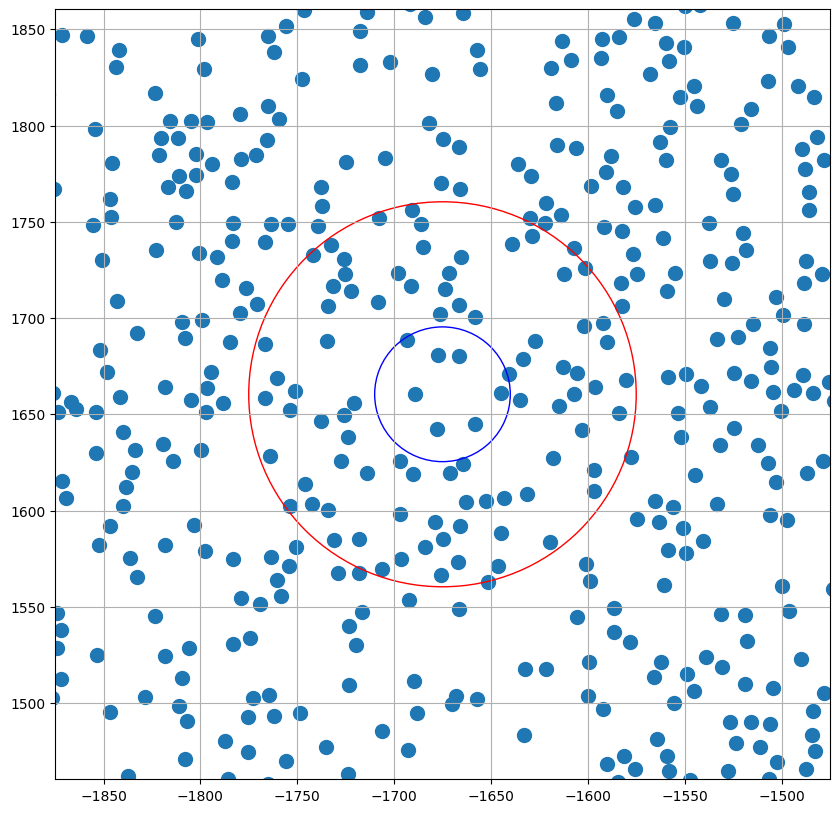

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(adata.obsm['spatial'][:, 0],  adata.obsm['spatial'][:, 1], s=100)
plt.grid()

center_x = adata.obsm['spatial'][:, 0].mean()
center_y = adata.obsm['spatial'][:, 1].mean()
plt.xlim(center_x-200, center_x+200)
plt.ylim(center_y-200, center_y+200)

circle1 = plt.Circle((center_x, center_y), 100, color='r', fill=False)
circle2 = plt.Circle((center_x, center_y), 35, color='b', fill=False)

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)

plt.show()

In [11]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    # colinks_path='/ix/djishnu/shared/djishnu_kor11/training_data_2025/mLND3-1_v4_colinks.pkl',
    colinks_path='/Users/koush/Desktop/training_data/mLND3-1_v4_colinks.pkl',
    annot='cell_type_int'
)

from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata=adata,
    target_gene='Cd74',
    layer='imputed_count',
    cluster_annot='cell_type_int', 
    grn=co_grn,
    radius=100,
    contact_distance=30
)

In [13]:
estimator.fit(num_epochs=1, learning_rate=5e-3, score_threshold=0.1)

Fitting Cd74 with 204 modulators
	22 Transcription Factors
	130 Ligand-Receptor Pairs
	52 TranscriptionFactor-Ligand Pairs
0: 0.7831 | 0.8405
1: 0.7188 | 0.8121
2: 0.3854 | 0.7275
3: 0.3220 | 0.6740
4: 0.6498 | 0.8600
5: 0.6489 | 0.8252
6: 0.6059 | 0.7802


In [5]:
from spaceoracle.prophets import Prophet

pythia = Prophet(
    adata=adata,
    models_dir='/ix/djishnu/shared/djishnu_kor11/super_filtered_runs/mLDN3-1_v4',
    annot='cell_type_int',
    annot_labels='cell_type',
    radius=100
)

In [6]:
pythia.compute_betas(subsample=10)

100%|██████████| 10/10 [00:00<00:00, 11.12it/s]
